# Cohort Analysis with Python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Cohort Analysis on Holiday Shoppers

Customers tend to purchase seasonally (end of the year holidays). Let's dive deeper to customers who first purchased on December 2009 and create cohorts based on number of transactions.

## Data Summary


We are given an online retail dataset containing transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.  
  
We are tasked to determine cohorts based on user retention and to provide insights and recommendations to improve customer loyalty.  

Our data contains the following columns:

1. **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.
2. **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. **Description**: Product (item) name. Nominal.
4. **Quantity**: The quantities of each product (item) per transaction. Numeric.
5. **InvoiceDate**: Invoice date and time. Numeric. The day and time when a transaction was generated.
6. **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
7. **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. **Country**: Country name. Nominal. The name of the country where a customer resides.

#Data Cleaning

In [ ]:
# We set Invoice and Customer ID as string types since they are the keys/ID for our dataset.
df = pd.read_csv('/content/drive/MyDrive/Cohort Analysis/online_retail.csv',
                   dtype={'Invoice':str, 'Customer ID':str},
                   parse_dates=['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [ ]:
# we are only interested in customers who first purchased on December 2009
# get list of customers first
customers = df.loc[df.InvoiceDate < datetime.datetime(2010,1,1), 'Customer ID'].unique()

In [ ]:
# filter the transactions
df = df[df['Customer ID'].isin(customers)]

In [ ]:
# remove cancellations (Invoices Starts with C)
df = df[~df['Invoice'].str.startswith('C')]

In [ ]:
# remove null customer IDs
df = df.dropna(subset=['Customer ID'])

In [ ]:
# Add new columns to extract the year and the month
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

In [ ]:
df_monthly = df.groupby(['Year', 'Month'])['Invoice'].nunique()

#Creating cohorts using customers with first purchase on December 2009. Grouping them by transaction count and generating a retention matrix.

In [ ]:
# remove duplicates
df_cohorts = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()

In [ ]:
# all first transaction month is December 2009
df_cohorts['first_txn'] = datetime.datetime(2009, 12, 1)
# convert to year-month
df_cohorts['first_txn'] = df_cohorts['first_txn'].dt.to_period('M')

In [ ]:
df_cohorts

,Customer ID,Invoice,InvoiceDate,first_txn
0,13085,489434,2009-12-01 07:45:00,2009-12
8,13085,489435,2009-12-01 07:46:00,2009-12
12,13078,489436,2009-12-01 09:06:00,2009-12
31,15362,489437,2009-12-01 09:08:00,2009-12
54,18102,489438,2009-12-01 09:24:00,2009-12
...,...,...,...,...
525283,14031,538165,2010-12-09 17:34:00,2009-12
525286,17965,538166,2010-12-09 18:09:00,2009-12
525303,14713,538167,2010-12-09 18:58:00,2009-12
525328,14702,538168,2010-12-09 19:23:00,2009-12


In [ ]:
# Add column for transaction count
# group by Customer ID and rank by ascending InvoiceDate
df_cohorts['txn_count'] = df_cohorts.groupby('Customer ID')['InvoiceDate'].rank(method='min')

In [ ]:
df_cohorts['txn_month'] = df_cohorts['InvoiceDate'].dt.to_period('M')

In [ ]:
df_cohorts

,Customer ID,Invoice,InvoiceDate,first_txn,txn_count,txn_month
0,13085,489434,2009-12-01 07:45:00,2009-12,1.0,2009-12
8,13085,489435,2009-12-01 07:46:00,2009-12,2.0,2009-12
12,13078,489436,2009-12-01 09:06:00,2009-12,1.0,2009-12
31,15362,489437,2009-12-01 09:08:00,2009-12,1.0,2009-12
54,18102,489438,2009-12-01 09:24:00,2009-12,1.0,2009-12
...,...,...,...,...,...,...
525283,14031,538165,2010-12-09 17:34:00,2009-12,27.0,2010-12
525286,17965,538166,2010-12-09 18:09:00,2009-12,17.0,2010-12
525303,14713,538167,2010-12-09 18:58:00,2009-12,11.0,2010-12
525328,14702,538168,2010-12-09 19:23:00,2009-12,13.0,2010-12


In [ ]:
# Group by transaction count, transaction month, first transaction date
df_cohorts = df_cohorts.groupby(['txn_month', 'txn_count', 'first_txn'])['Customer ID'].nunique()
df_cohorts.name = 'num_customers'
df_cohorts = df_cohorts.reset_index()

In [ ]:
df_cohorts

,txn_month,txn_count,first_txn,num_customers
0,2009-12,1.0,2009-12,955
1,2009-12,2.0,2009-12,282
2,2009-12,3.0,2009-12,113
3,2009-12,4.0,2009-12,52
4,2009-12,5.0,2009-12,30
...,...,...,...,...
1054,2010-12,202.0,2009-12,1
1055,2010-12,203.0,2009-12,1
1056,2010-12,204.0,2009-12,1
1057,2010-12,205.0,2009-12,1


In [ ]:
# subtract first_txn from txn_month, this will result in a MonthEnd pandas datatype
# to get the value as integer, we use the pandas apply function
df_cohorts['period_number'] = (df_cohorts.txn_month - df_cohorts.first_txn).apply(lambda x: x.n)

In [ ]:
df_cohorts

,txn_month,txn_count,first_txn,num_customers,period_number
0,2009-12,1.0,2009-12,955,0
1,2009-12,2.0,2009-12,282,0
2,2009-12,3.0,2009-12,113,0
3,2009-12,4.0,2009-12,52,0
4,2009-12,5.0,2009-12,30,0
...,...,...,...,...,...
1054,2010-12,202.0,2009-12,1,12
1055,2010-12,203.0,2009-12,1,12
1056,2010-12,204.0,2009-12,1,12
1057,2010-12,205.0,2009-12,1,12


In [ ]:
df_pivot = df_cohorts.pivot_table(index='txn_count', columns='period_number', values='num_customers')
df_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
txn_count,,,,,,,,,,,,,
1.0,955.0,18.0,15.0,14.0,9.0,2.0,6.0,2.0,1.0,1.0,2.0,2.0,NaN
2.0,282.0,190.0,91.0,109.0,53.0,48.0,36.0,17.0,16.0,16.0,26.0,24.0,NaN
3.0,113.0,100.0,117.0,100.0,94.0,56.0,44.0,31.0,24.0,33.0,37.0,38.0,11.0
4.0,52.0,63.0,77.0,101.0,66.0,57.0,57.0,46.0,30.0,34.0,52.0,43.0,8.0
5.0,30.0,39.0,55.0,56.0,67.0,65.0,58.0,44.0,33.0,35.0,39.0,60.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
# get the original cohort size - based on how many customers have a given txn_count
df_orig_cohorts = df_pivot.sum(axis=1)

In [ ]:
# divide by original cohort size
df_pivot = df_pivot.divide(df_orig_cohorts, axis=0)
df_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
txn_count,,,,,,,,,,,,,
1.0,0.929893,0.017527,0.014606,0.013632,0.008763,0.001947,0.005842,0.001947,0.000974,0.000974,0.001947,0.001947,NaN
2.0,0.310573,0.209251,0.100220,0.120044,0.058370,0.052863,0.039648,0.018722,0.017621,0.017621,0.028634,0.026432,NaN
3.0,0.141604,0.125313,0.146617,0.125313,0.117794,0.070175,0.055138,0.038847,0.030075,0.041353,0.046366,0.047619,0.013784
4.0,0.075802,0.091837,0.112245,0.147230,0.096210,0.083090,0.083090,0.067055,0.043732,0.049563,0.075802,0.062682,0.011662
5.0,0.050420,0.065546,0.092437,0.094118,0.112605,0.109244,0.097479,0.073950,0.055462,0.058824,0.065546,0.100840,0.023529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


#Generating Insights by Analyzing Plots

Analysis using plots and providing recommendations.

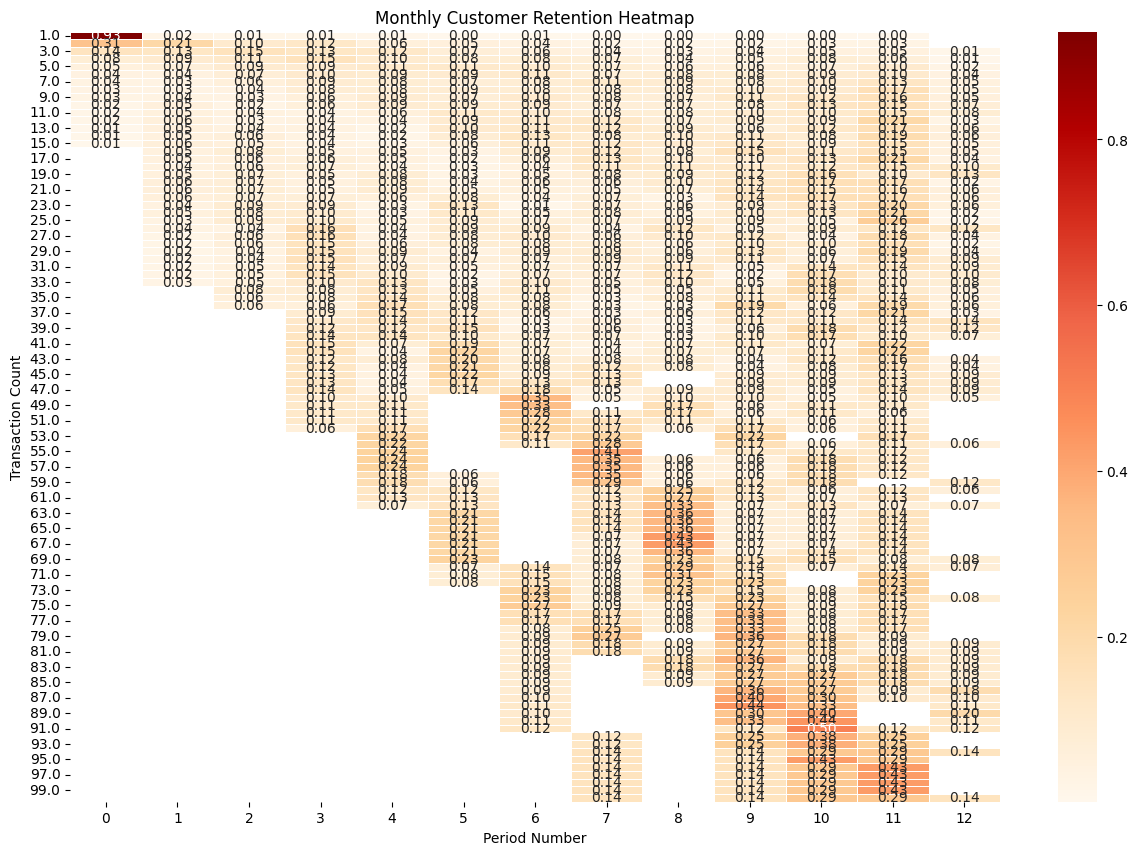

In [ ]:
import matplotlib
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):


    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}


    im = ax.imshow(df_pivot.values, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(df_pivot.columns)
    ax.set_yticklabels(df_pivot.index)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")
    for _, spine in ax.spines.items():
      spine.set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

row_labels = df_pivot.index.tolist()
col_labels = df_pivot.columns.tolist()

subset_data = df_pivot.iloc[:100, :]

plt.figure(figsize=(15, 10))
ax = sns.heatmap(subset_data, cmap="OrRd", annot=True, fmt=".2f", linewidths=0.5)


plt.title("Monthly Customer Retention Heatmap")
plt.xlabel("Period Number")
plt.ylabel("Transaction Count")

plt.show()

Insights:

1. Around 93% of customers have done a re-purchase during the month of December 2019.

2. It is quite prevalent that customer retention has been on a decline at the start of 2010, this could indicate that most customer sales was due to Christmas and New Year season.  

3. Only a few customer retained after making their first purchase on the first month which is December 2019.

Recommendations:

1. Considering that the customer retention rate is too low, the company may employ some of the following strategies:

  a. sending newsletters

  b. loyalty programs

  c. customer feedback

  d. offering deals for best selling items

  e. studying the data from the online store to pin point items that are popular with people and communicate with wholesale buyers